# SUJET : Human Protein Atlas Image Classification

Le but du projet est de prevoir des étiquettes de localisation des organites de protéines pour chaque échantillon. Au total, 28 étiquettes différentes sont présentes dans l'ensemble de données. L'ensemble de données est acquis de manière hautement normalisée en utilisant une modalité d'imagerie (microscopie confocale). Cependant, l'ensemble de données comprend 27 types de cellules de morphologie très différente, qui affectent les profils protéiques des différents organites. Tous les échantillons d'images sont représentés par quatre filtres (stockés sous forme de fichiers individuels), la protéine d'intérêt (vert) et trois repères cellulaires: noyau (bleu), microtubules (rouge), réticulum endoplasmique (jaune). Le filtre vert devrait donc être utilisé pour prédire l'étiquette, et les autres filtres sont utilisés comme références.

0.  Nucleoplasm  
1.  Nuclear membrane   
2.  Nucleoli   
3.  Nucleoli fibrillar center   
4.  Nuclear speckles   
5.  Nuclear bodies   
6.  Endoplasmic reticulum   
7.  Golgi apparatus   
8.  Peroxisomes   
9.  Endosomes   
10.  Lysosomes   
11.  Intermediate filaments   
12.  Actin filaments   
13.  Focal adhesion sites   
14.  Microtubules   
15.  Microtubule ends   
16.  Cytokinetic bridge   
17.  Mitotic spindle   
18.  Microtubule organizing center   
19.  Centrosome   
20.  Lipid droplets   
21.  Plasma membrane   
22.  Cell junctions   
23.  Mitochondria   
24.  Aggresome   
25.  Cytosol   
26.  Cytoplasmic bodies   
27.  Rods & rings  

Image entrainement : 32 072
Image suoumission : 11 702

# IMPORT

In [52]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from skimage.io import imread
import cv2
from skimage.transform import resize
from sklearn.model_selection import StratifiedKFold
from skimage.filters import try_all_threshold

**ANALYSE DE DONNEES **

In [53]:
df=pd.read_csv('../input/train.csv', index_col=0)
df.head()

,Target
Id,
00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [54]:
images=[imread('../input/train/'+x+'_green.png', as_gray=True) for x in df.index]
print(images[0].shape)
df['Image']=images

(512, 512)


/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_base.py:1428: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)
/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_base.py:1428: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)
/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_base.py:1428: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)
/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_base.py:1428: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)
/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_base.py:1428: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)
/opt/conda

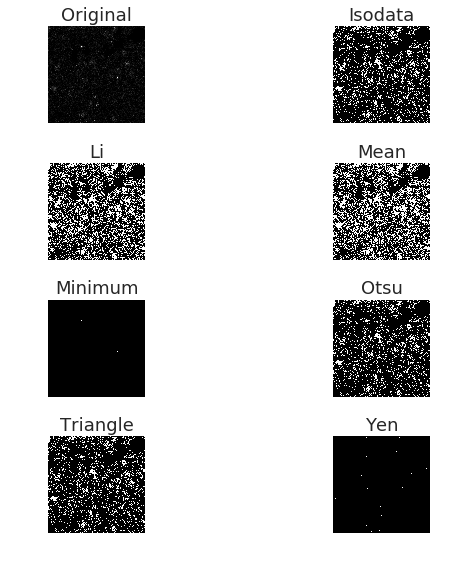

In [55]:
fig, ax = try_all_threshold(df.iloc[0, 1], figsize=(10, 8), verbose=False)
plt.show()

In [56]:
df['Hist']=df['Image'].apply(lambda x: np.histogram(x, 128)[0])
#df.head()
#Histogramme

Exemple images avec leurs classes respectives


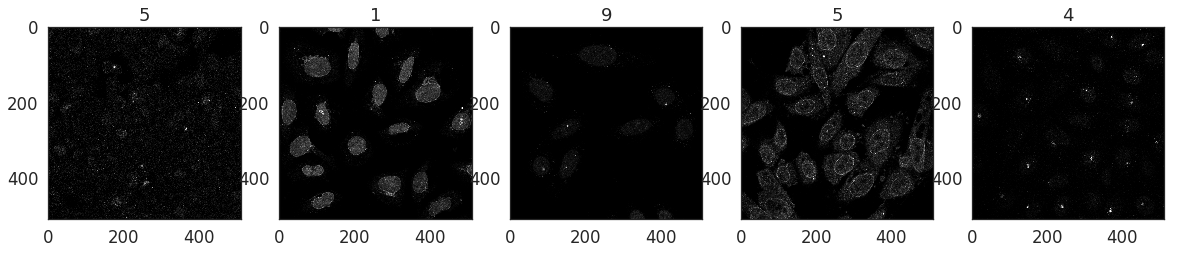

In [57]:
from sklearn.cluster import KMeans
clusters=10
kmeans=KMeans(clusters)
df['Cluster']=kmeans.fit_predict([np.array(x) for x in df['Hist'].values])
df.head()
shape=[1, 5]
fig=plt.figure(figsize=(20, 35))
for i in range(shape[0]*shape[1]):
    sub=plt.subplot(shape[0], shape[1], i+1)
    sub.set_title(df.iloc[i, 3])
    plt.imshow(df.iloc[i, 1])
print('Exemple images avec leurs classes respectives')
plt.show()

In [58]:
%matplotlib inline 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from PIL import Image


data_train_dir = r'../input/train'
answer_file_path = r'../input/train.csv'

channels = ['_yellow', '_red', '_green', '_blue']

index_class_dict = {
    0: "Nucleoplasm",
    1: "Nuclear membrane",
    2: "Nucleoli",
    3: "Nucleoli fibrillar center",
    4: "Nuclear speckles",
    5: "Nuclear bodies",
    6: "Endoplasmic reticulum",
    7: "Golgi apparatus",
    8: "Peroxisomes",
    9: "Endosomes",
    10: "Lysosomes",
    11: "Intermediate filaments",
    12: "Actin filaments",
    13: "Focal adhesion sites",
    14: "Microtubules",
    15: "Microtubule ends",
    16: "Cytokinetic bridge",
    17: "Mitotic spindle",
    18: "Microtubule organizing center",
    19: "Centrosome",
    20: "Lipid droplets",
    21: "Plasma membrane",
    22: "Cell junctions",
    23: "Mitochondria",
    24: "Aggresome",
    25: "Cytosol",
    26: "Cytoplasmic bodies",
    27: "Rods & rings"
}

train_df = pd.read_csv(answer_file_path)

In [59]:
train_df[f'target_vec'] = train_df['Target'].map(lambda x: list(map(int, x.strip().split())))
for i in range(28):
    train_df[f'{index_class_dict[i]}'] = train_df['Target'].map(
             lambda x: 1 if str(i) in x.strip().split() else 0)
#train_df.head()


**IMAGE EN RGBY**

In [60]:
class_index = 1  # Nuclear membrane
current_part = train_df[train_df[index_class_dict[class_index]] == 1]

In [61]:
#Functions for visualization
def make_rgb_image_from_four_channels(channels: list, image_width=512, image_height=512) -> np.ndarray:
    """
     On crée une immage RGBY à partir des 4 filtres
      
    """
    rgb_image = np.zeros(shape=(image_height, image_width, 3), dtype=np.float)
    yellow = np.array(Image.open(channels[0]))
    # yellow is red + green
    rgb_image[:, :, 0] += yellow/2   
    rgb_image[:, :, 1] += yellow/2
    # loop for R,G and B channels
    for index, channel in enumerate(channels[1:]):
        current_image = Image.open(channel)
        rgb_image[:, :, index] += current_image
    # Normalize image
    rgb_image = rgb_image / rgb_image.max() * 255
    return rgb_image.astype(np.uint8)
def visualize_part(start_class_index=0, nrows=4, ncols=3):
    fig, ax = plt.subplots(nrows = nrows, ncols=ncols, figsize=(15, 25))
    for class_index in range(nrows):
        current_index = class_index + start_class_index
        for sample in range(ncols):
            current_part = train_df[train_df[index_class_dict[current_index]] == 1] 
            # 0 index is id
            random_index = np.random.choice(current_part.values.shape[0], 1, replace=False)
            # random line from data with selected class
            current_line = current_part.values[random_index][0]
            image_names = [os.path.join(data_train_dir, current_line[0]) 
                           + x + '.png' for x in channels]
            rgb_image = make_rgb_image_from_four_channels(image_names)
            # text annotations, main title and subclasses (may be empty in case one label)
            main_class = index_class_dict[current_index]+'\n'
            # 2 index is vector with classes, split version of Target col
            other_classes = [index_class_dict[x] for x in current_line[2] 
                             if x != (current_index)]
            subtitle = ', '.join(other_classes)
            # show image
            ax[class_index, sample].set_title(main_class, fontsize=18)
            ax[class_index, sample].text(250, -10, subtitle, 
                                         fontsize=14, horizontalalignment='center')
            ax[class_index, sample].imshow(rgb_image)
            ax[class_index, sample].set_xticklabels([])
            ax[class_index, sample].set_yticklabels([])
            ax[class_index, sample].tick_params(left=False, bottom=False)

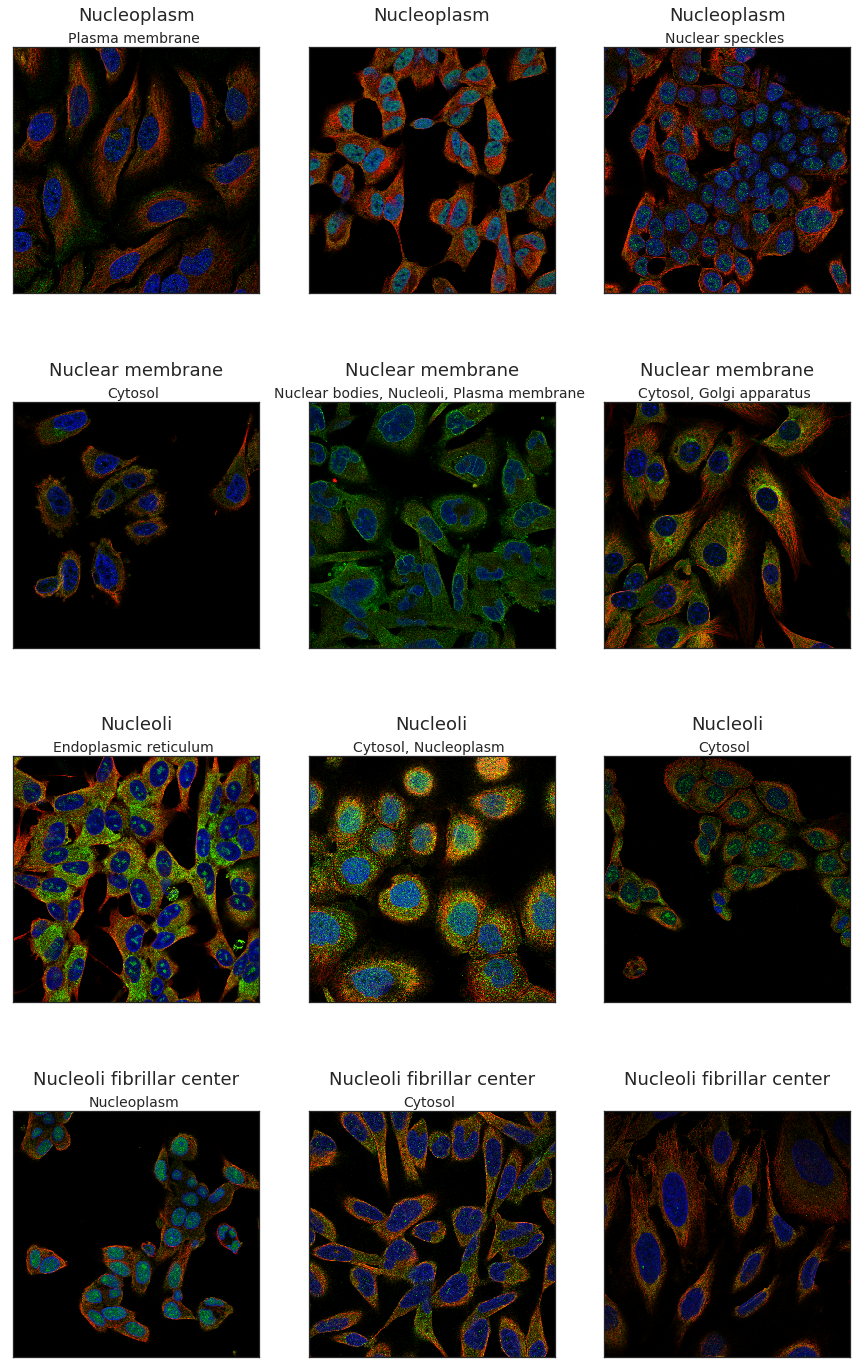

In [62]:
#visualize 3 examples for each class (4*3)
visualize_part(0)

In [63]:
#class study
import numpy as np
import pandas as pd 
import seaborn as sns
import os
from itertools import chain
from collections import Counter
sns.set_style("white")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

#from keras.preprocessing.image import load_img
from matplotlib import pyplot as plt
%matplotlib inline

In [64]:
df = pd.read_csv('../input/train.csv')
def count_target(target_val):
    return len(target_val.split(' '))

df['nclass'] = df.Target.map(count_target)

In [65]:
#Function for plotting the images

def plot_img(img_id):
    filt_no = 0
    plt.figure(figsize=(30,60))
    plt.tight_layout()
    for filt in img_filt:
        img_path = train_img_path + img_id + filt
        img = np.array(load_img(img_path))
        plt.subplot(1,4,filt_no+1)
        plt.imshow(img)
        if i==0: plt.title(filt[1:-4]+' filter')
        plt.axis('off')
        filt_no += 1 

In [66]:
#Label Count Distribribution

label_count = []
for i in range(df.nclass.min(),df.nclass.max()+1):
    label_count.append(np.sum(df.nclass==i))
    print('No. of images with',i,'label:',label_count[-1])

No. of images with 1 label: 15126
No. of images with 2 label: 12485
No. of images with 3 label: 3160
No. of images with 4 label: 299
No. of images with 5 label: 2


Text(0.5,1,'Distribution du nombre de classe par image')

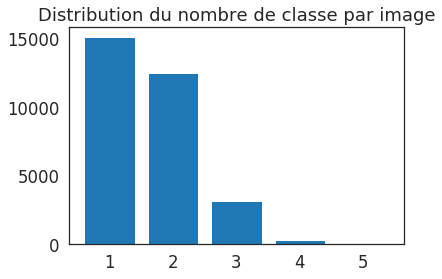

In [67]:
x = np.arange(len(label_count))+1
plt.bar(x,label_count)
plt.title('Distribution du nombre de classe par image' )

In [68]:
#Plotting the image with the histogram
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
plt.gray()
import skimage.filters
import scipy.ndimage
import sklearn.feature_extraction
import sklearn.cluster
import skimage.feature
import skimage.transform
import PIL
import sys



<Figure size 432x288 with 0 Axes>

In [69]:
def plot_file(filename):
    image = plt.imread(filename)
    hist = np.histogram(image - image.mean(),
                        bins=np.arange(image.min(),
                                       image.max(),
                                       1/256))

    fig, axes = plt.subplots(1, 2, figsize=(8, 3))
    
    axes[0].imshow(image, interpolation='nearest')
    axes[0].axis('off')
    axes[0].set_title(filename[-20:])
    
    axes[1].plot(hist[1][:-1], hist[0], lw=2)
    axes[1].set_title('histogram of gray values')
    
    plt.show()

In [70]:
#plot_file('../input/train/002daad6-bbc9-11e8-b2bc-ac1f6b6435d0_red.png')
#plot_file('../input/train/002daad6-bbc9-11e8-b2bc-ac1f6b6435d0_green.png')
#plot_file('../input/train/002daad6-bbc9-11e8-b2bc-ac1f6b6435d0_blue.png')
#plot_file('../input/train/002daad6-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png')

In [71]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import itertools as itt
import networkx as nx
from sklearn.preprocessing import MinMaxScaler


In [72]:
train_labels = pd.read_csv("../input/train.csv")

In [73]:
label_names = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}

#reverse_train_labels = dict((v,k) for k,v in label_names.items())

def fill_targets(row):
    row.Target = np.array(row.Target.split(" ")).astype(np.int)
    for num in row.Target:
        name = label_names[int(num)]
        row.loc[name] = 1
    return row

In [74]:
for key in label_names.keys():
    train_labels[label_names[key]] = 0

In [75]:
train_labels = train_labels.apply(fill_targets, axis=1)

Text(0.5,1,'Redondance des différentes classes ')

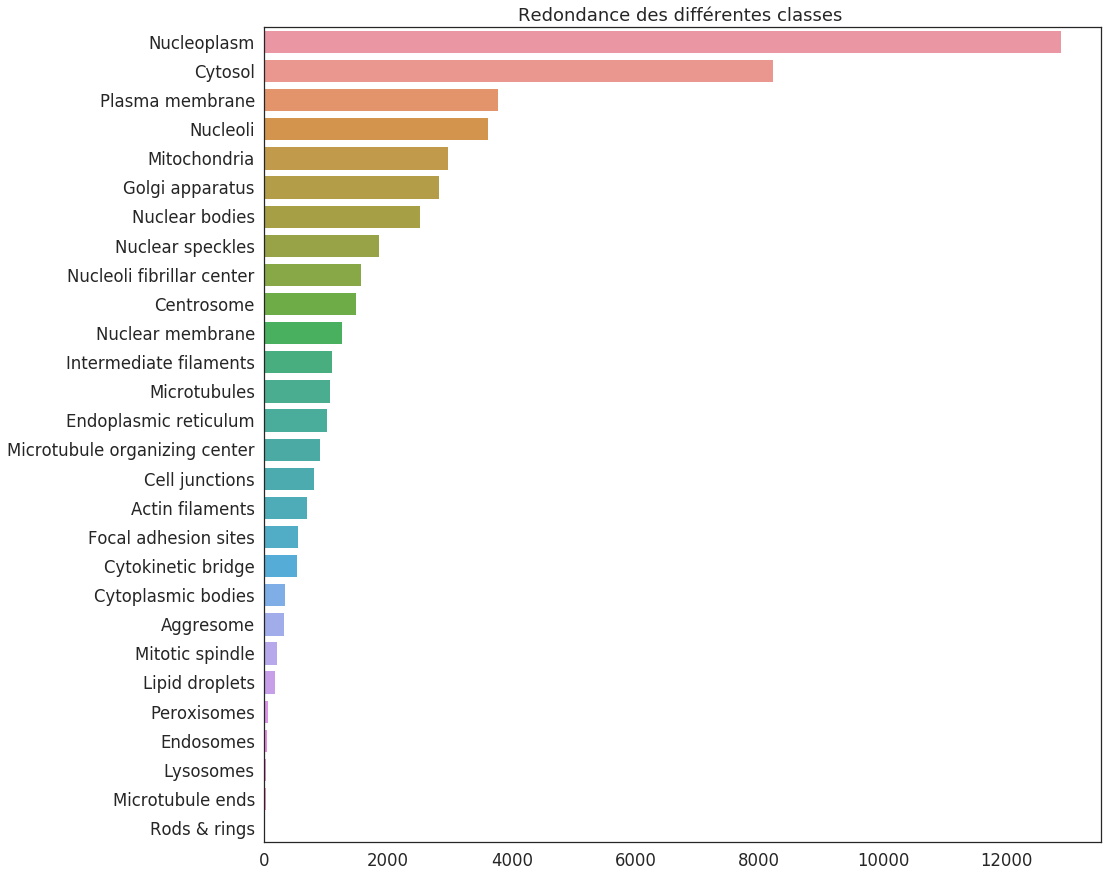

In [76]:
target_counts = train_labels.drop(["Id", "Target"],axis=1).sum(axis=0).sort_values(ascending=False)
plt.figure(figsize=(15,15))
sns.barplot(y=target_counts.index.values, x=target_counts.values, order=target_counts.index)
plt.title('Redondance des différentes classes ')

In [77]:
print('Classes les moins répandu')
target_counts.tail()

Classes les moins répandu


Peroxisomes         53
Endosomes           45
Lysosomes           28
Microtubule ends    21
Rods & rings        11
dtype: int64

In [78]:
train_labels["Nombre de Classe par Image"] = train_labels.drop(["Id", "Target"],axis=1).sum(axis=1)


In [79]:
count_perc = train_labels.groupby("Nombre de Classe par Image").count()['Id']
count_perc

Nombre de Classe par Image
1    15126
2    12485
3     3160
4      299
5        2
Name: Id, dtype: int64

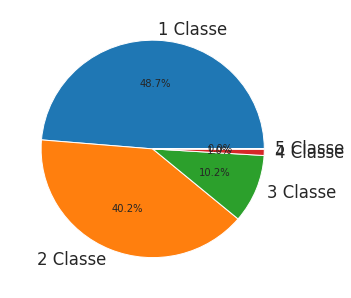

In [80]:
plt.figure(figsize=(5,5))
plt.pie(count_perc,
        labels=["%d Classe" % x for x in count_perc.index],
        autopct='%1.1f%%')
plt.ylabel('');

**MISE EN PLACE DE LA SOLUTION**

**IMPORT**

In [81]:
import sys
import numpy as np
import keras
from keras.utils import Sequence
from PIL import Image
from matplotlib import pyplot as plt
import pandas as pd
from tqdm import tqdm
import os
import imgaug as ia
from imgaug import augmenters as iaa
import cv2

In [82]:
BATCH_SIZE = 32
SEED = 777
SHAPE = (512, 512, 4) 
DIR = '../input'

** SEUIL DE VALIDATION **

In [83]:
VAL_RATIO = 0.1 # 10 % de validation
THRESHOLD = 0.5 # seuil de probabilité de prédire que l'image appartient à la classe 
ia.seed(SEED)

In [84]:
def getTrainDataset():
    
    path_to_train = DIR + '/train/'
    data = pd.read_csv(DIR + '/train.csv')

    paths = []
    labels = []
    
    for name, lbl in zip(data['Id'], data['Target'].str.split(' ')):
        y = np.zeros(28)
        for key in lbl:
            y[int(key)] = 1
        paths.append(os.path.join(path_to_train, name))
        labels.append(y)

    return np.array(paths), np.array(labels)

def getTestDataset():
    
    path_to_test = DIR + '/test/'
    data = pd.read_csv(DIR + '/sample_submission.csv')

    paths = []
    labels = []
    
    for name in data['Id']:
        y = np.ones(28)
        paths.append(os.path.join(path_to_test, name))
        labels.append(y)

    return np.array(paths), np.array(labels)

In [85]:
class ProteinDataGenerator(keras.utils.Sequence):
            
    def __init__(self, paths, labels, batch_size, shape, shuffle = False, use_cache = False, augment = False):
        self.paths, self.labels = paths, labels
        self.batch_size = batch_size
        self.shape = shape
        self.shuffle = shuffle
        self.use_cache = use_cache
        self.augment = augment
        if use_cache == True:
            self.cache = np.zeros((paths.shape[0], shape[0], shape[1], shape[2]), dtype=np.float16)
            self.is_cached = np.zeros((paths.shape[0]))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.paths) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        indexes = self.indexes[idx * self.batch_size : (idx+1) * self.batch_size]

        paths = self.paths[indexes]
        X = np.zeros((paths.shape[0], self.shape[0], self.shape[1], self.shape[2]))
        # Generate data
        if self.use_cache == True:
            X = self.cache[indexes]
            for i, path in enumerate(paths[np.where(self.is_cached[indexes] == 0)]):
                image = self.__load_image(path)
                self.is_cached[indexes[i]] = 1
                self.cache[indexes[i]] = image
                X[i] = image
        else:
            for i, path in enumerate(paths):
                X[i] = self.__load_image(path)

        y = self.labels[indexes]
                
        if self.augment == True:
            seq = iaa.Sequential([
                iaa.OneOf([
                    iaa.Fliplr(0.5), # horizontal flips
                    iaa.Crop(percent=(0, 0.1)), # random crops
                    # Small gaussian blur with random sigma between 0 and 0.5.
                    # But we only blur about 50% of all images.
                    iaa.Sometimes(0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    # Strengthen or weaken the contrast in each image.
                    iaa.ContrastNormalization((0.75, 1.5)),
                    # Add gaussian noise.
                    # For 50% of all images, we sample the noise once per pixel.
                    # For the other 50% of all images, we sample the noise per pixel AND
                    # channel. This can change the color (not only brightness) of the
                    # pixels.
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                    # Make some images brighter and some darker.
                    # In 20% of all cases, we sample the multiplier once per channel,
                    # which can end up changing the color of the images.
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    # Apply affine transformations to each image.
                    # Scale/zoom them, translate/move them, rotate them and shear them.
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                        rotate=(-180, 180),
                        shear=(-8, 8)
                    )
                ])], random_order=True)

            X = np.concatenate((X, seq.augment_images(X), seq.augment_images(X), seq.augment_images(X)), 0)
            y = np.concatenate((y, y, y, y), 0)
        
        return X, y
    
    def on_epoch_end(self):
        
        # Updates indexes after each epoch
        self.indexes = np.arange(len(self.paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __iter__(self):
        """Create a generator that iterate over the Sequence."""
        for item in (self[i] for i in range(len(self))):
            yield item
            
    #Load the images in RGBY
    def __load_image(self, path):
        R = Image.open(path + '_red.png')
        G = Image.open(path + '_green.png')
        B = Image.open(path + '_blue.png')
        Y = Image.open(path + '_yellow.png')

        im = np.stack((
            np.array(R), 
            np.array(G), 
            np.array(B),
            np.array(Y)), -1)
        
        im = cv2.resize(im, (SHAPE[0], SHAPE[1]))
        im = np.divide(im, 255)
        return im

**Keras**

In [86]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
from keras.layers import Activation, Dropout, Flatten, Dense, Input, Conv2D, MaxPooling2D, BatchNormalization, Concatenate, ReLU, LeakyReLU, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras import metrics
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K
import keras
import tensorflow as tf

from tensorflow import set_random_seed
set_random_seed(SEED)

In [87]:
def f1(y_true, y_pred):
    #y_pred = K.round(y_pred)
    #y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), THRESHOLD), K.floatx())
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    #y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), THRESHOLD), K.floatx())
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1-K.mean(f1)

**CREATION DU MODEL**

In [88]:
def create_model(input_shape):
    
    dropRate = 0.25
    
    init = Input(input_shape)
    x = BatchNormalization(axis=-1)(init)
    x = Conv2D(32, (3, 3))(x) #, strides=(2,2))(x)
    x = ReLU()(x)

    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    ginp1 = Dropout(dropRate)(x)
    
    x = BatchNormalization(axis=-1)(ginp1)
    x = Conv2D(64, (3, 3), strides=(2,2))(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(64, (3, 3))(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(64, (3, 3))(x)
    x = ReLU()(x)
    
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    ginp2 = Dropout(dropRate)(x)
    
    x = BatchNormalization(axis=-1)(ginp2)
    x = Conv2D(128, (3, 3))(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(128, (3, 3))(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(128, (3, 3))(x)
    x = ReLU()(x)
    ginp3 = Dropout(dropRate)(x)
    
    gap1 = GlobalAveragePooling2D()(ginp1)
    gap2 = GlobalAveragePooling2D()(ginp2)
    gap3 = GlobalAveragePooling2D()(ginp3)
    
    x = Concatenate()([gap1, gap2, gap3])
    
    x = BatchNormalization(axis=-1)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(dropRate)(x)
    
    x = BatchNormalization(axis=-1)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.1)(x)
    
    x = Dense(28)(x)
    x = Activation('sigmoid')(x)
    
    model = Model(init, x)
    
    return model

In [89]:
model = create_model(SHAPE)
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(1e-03),
    metrics=['acc',f1])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 512, 512, 4)  0                                            
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 512, 512, 4)  16          input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 510, 510, 32) 1184        batch_normalization_12[0][0]     
__________________________________________________________________________________________________
re_lu_8 (ReLU)                  (None, 510, 510, 32) 0           conv2d_8[0][0]                   
__________________________________________________________________________________________________
batch_norm

In [90]:
paths, labels = getTrainDataset()

# divide to 
keys = np.arange(paths.shape[0], dtype=np.int)  
np.random.seed(SEED)
np.random.shuffle(keys)
lastTrainIndex = int((1-VAL_RATIO) * paths.shape[0])

pathsTrain = paths[0:lastTrainIndex]
labelsTrain = labels[0:lastTrainIndex]
pathsVal = paths[lastTrainIndex:]
labelsVal = labels[lastTrainIndex:]

print(paths.shape, labels.shape)
print(pathsTrain.shape, labelsTrain.shape, pathsVal.shape, labelsVal.shape)

tg = ProteinDataGenerator(pathsTrain, labelsTrain, BATCH_SIZE, SHAPE, use_cache=False, augment = False, shuffle = False)
vg = ProteinDataGenerator(pathsVal, labelsVal, BATCH_SIZE, SHAPE, use_cache=False, shuffle = False)

checkpoint = ModelCheckpoint('./base.model', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='min', period=1)
reduceLROnPlato = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, mode='min')

(31072,) (31072, 28)
(27964,) (27964, 28) (3108,) (3108, 28)


In [91]:
use_multiprocessing = False 
workers = 1 

**ENTRAINEMENT DU MODEL**

In [ ]:
""""
epochs = 4

hist = model.fit_generator(
    tg,
    steps_per_epoch=len(tg),
    validation_data=vg,
    validation_steps=8,
    epochs=epochs,
    use_multiprocessing=use_multiprocessing,
    workers=workers,
    verbose=1,
    callbacks=[checkpoint])
"""""


In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].set_title('loss')
ax[0].plot(hist.epoch, hist.history["loss"], label="Train loss")
ax[0].plot(hist.epoch, hist.history["val_loss"], label="Validation loss")
ax[1].set_title('acc')
ax[1].plot(hist.epoch, hist.history["f1"], label="Train F1")
ax[1].plot(hist.epoch, hist.history["val_f1"], label="Validation F1")
ax[0].legend()
ax[1].legend()

In [ ]:
for layer in model.layers:
    layer.trainable = False
    
model.layers[-1].trainable = True
model.layers[-2].trainable = True
model.layers[-3].trainable = True
model.layers[-4].trainable = True
model.layers[-5].trainable = True
model.layers[-6].trainable = True
model.layers[-7].trainable = True

model.compile(loss=f1_loss,
            optimizer=Adam(lr=1e-4),
            metrics=['accuracy', f1])

model.fit_generator(
    tg,
    steps_per_epoch=len(tg),
    validation_data=vg,
    validation_steps=8,
    epochs=1,
    use_multiprocessing=use_multiprocessing, # you have to train the model on GPU in order to this to be benefitial
    workers=workers, # you have to train the model on GPU in order to this to be benefitial
    verbose=1,
    max_queue_size=4
)

**VALIDATION**

Choisir le seuil de prédiction approprié maximisant le score de validation F1.

In [ ]:
bestModel = load_model('./base.model', custom_objects={'f1': f1})
#bestModel = model

In [ ]:
fullValGen = vg

In [ ]:
from sklearn.metrics import f1_score as off1

def getOptimalT(mdl, fullValGen):
    
    lastFullValPred = np.empty((0, 28))
    lastFullValLabels = np.empty((0, 28))
    for i in tqdm(range(len(fullValGen))): 
        im, lbl = fullValGen[i]
        scores = mdl.predict(im)
        lastFullValPred = np.append(lastFullValPred, scores, axis=0)
        lastFullValLabels = np.append(lastFullValLabels, lbl, axis=0)
    print(lastFullValPred.shape, lastFullValLabels.shape)
    
    rng = np.arange(0, 1, 0.001)
    f1s = np.zeros((rng.shape[0], 28))
    for j,t in enumerate(tqdm(rng)):
        for i in range(28):
            p = np.array(lastFullValPred[:,i]>t, dtype=np.int8)
            #scoref1 = K.eval(f1_score(fullValLabels[:,i], p, average='binary'))
            scoref1 = off1(lastFullValLabels[:,i], p, average='binary')
            f1s[j,i] = scoref1
            
    print(np.max(f1s, axis=0))
    print(np.mean(np.max(f1s, axis=0)))
    
    plt.plot(rng, f1s)
    T = np.empty(28)
    for i in range(28):
        T[i] = rng[np.where(f1s[:,i] == np.max(f1s[:,i]))[0][0]]
    #print('Choosing threshold: ', T, ', validation F1-score: ', max(f1s))
    print(T)
    
    return T, np.mean(np.max(f1s, axis=0))

In [ ]:
fullValGen = ProteinDataGenerator(paths[lastTrainIndex:], labels[lastTrainIndex:], BATCH_SIZE, SHAPE)
print('Last model after fine-tuning')
T1, ff1 = getOptimalT(model, fullValGen)

In [ ]:
print('Best save model')
T2, ff2 = getOptimalT(bestModel, fullValGen)

In [ ]:
if ff1 > ff2:
    T = T1
    bestModel = model
else:
    T = T2
    bestModel = bestModel

In [ ]:
pathsTest, labelsTest = getTestDataset()

testg = ProteinDataGenerator(pathsTest, labelsTest, BATCH_SIZE, SHAPE)
submit = pd.read_csv(DIR + '/sample_submission.csv')
P = np.zeros((pathsTest.shape[0], 28))
for i in tqdm(range(len(testg))):
    images, labels = testg[i]
    score = bestModel.predict(images)
    P[i*BATCH_SIZE:i*BATCH_SIZE+score.shape[0]] = score

In [ ]:
PP = np.array(P)

In [ ]:
prediction = []

for row in tqdm(range(submit.shape[0])):
    
    str_label = ''
    
    for col in range(PP.shape[1]):
        if(PP[row, col] < T[col]):
            str_label += ''
        else:
            str_label += str(col) + ' '
    prediction.append(str_label.strip())
    
submit['Predicted'] = np.array(prediction)
submit.to_csv('RGBY_CNN.csv', index=False)